# Procesamiento de imágenes · Tarea 5

Cuando una imagen no se toma adecuadamente, lo ideal sería volver a tomarla. Sin embargo, resulta complicado lograr esto si el evento ya ocurrió hace un tiempo. En casos como este resulta útil mejorar la imagen con la ayuda del procesamiento de imágenes.

Tenemos una radiografía que tiene _motion blur_ porque la mochila se estaba moviendo mientras la fotografía fue tomada. Podemos estimar la función de degradación para intentar recuperar información de la imagen original.

### Importante
* Lee atentamente las instrucciones y todo el código.
* Ejecuta las celdas en orden.
* Escribe tu código en las celdas que lo soliciten.
* Usa los nombres de variables que te pidan.
* Confirma que tu código esté correcto corriendo las celdas que dicen "Chequeo".
* Si el chequeo alerta que hay alguna variable incorrecta, vuelve atrás y arréglala. No hay penalización por esto.


### Imagen degradada
<img src="xray_motion.png" alt="drawing" width="600"/>

### Imagen restaurada
<img src="xray_restored.png" alt="drawing" width="600"/>

Esta tarea será distinta a las anteriores. Serás libre de cumplir el objetivo a tu mandera. Puedes usar la librería y el código que desees.

[Aquí](https://scikit-image.org/docs/stable/auto_examples/filters/plot_restoration.html) y [aquí](https://docs.opencv.org/4.5.2/d1/dfd/tutorial_motion_deblur_filter.html) hay unos links que podrían servirte.

##### Importamos las librerías para el chequeo

## Primer problema

Nuestro fotógrafo, Alex, es fanático de los autos y quisiera saber la patente de este para conocer en detalle el modelo del auto. Lamentablemente, movió la cámara al sacar la foto y la patente quedó ilegible.

<img src="car_motion.png" alt="drawing" width="400"/>

Restaura la imagen para ayudar a Alex a recuperar la patente del auto. La imagen borrosa está almacenada en ```car_motion.png```. Escribe la patente que descubras (sin guiones ni espacios) en ```plate_1``` y la imagen resultante (como un ```numpy.ndarray```) en ```img_restored_1```. ¡Suerte!

Tip: si cargas la imagen con ```cv2.imread```, recuerda que los pixeles retornados son ```np.uint8``` y están entre 0 y 255. Algunas funciones de restauración reciben _floats_ entre 0 y 1 por lo que podrías necesitar modificar la imagen.

**Tip:** analiza las esquinas de la imagen para descubrir qué degradación fue aplicada.

In [1]:
# Escribe tu código en las siguientes líneas
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import color, data, restoration
from scipy.signal import convolve2d as conv2
from scipy import fftpack

plt.rcParams["figure.dpi"] = 150

Las dimensiones de la imagen son (810, 1060, 3)


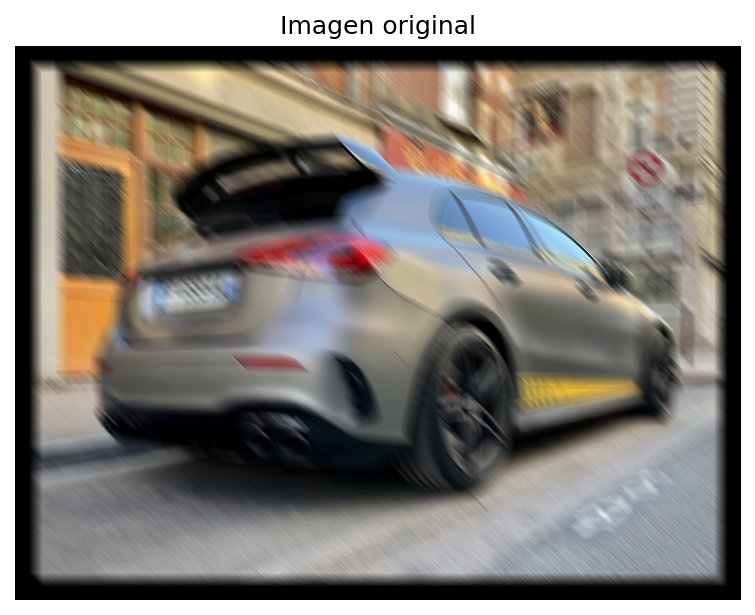

In [2]:
car_bgr = cv2.imread('car_motion.png', cv2.IMREAD_COLOR)
car_rgb = car_bgr[:,:,::-1]
print(f"Las dimensiones de la imagen son {car_rgb.shape}")
plt.imshow(car_rgb)
plt.title('Imagen original')
plt.axis('off');

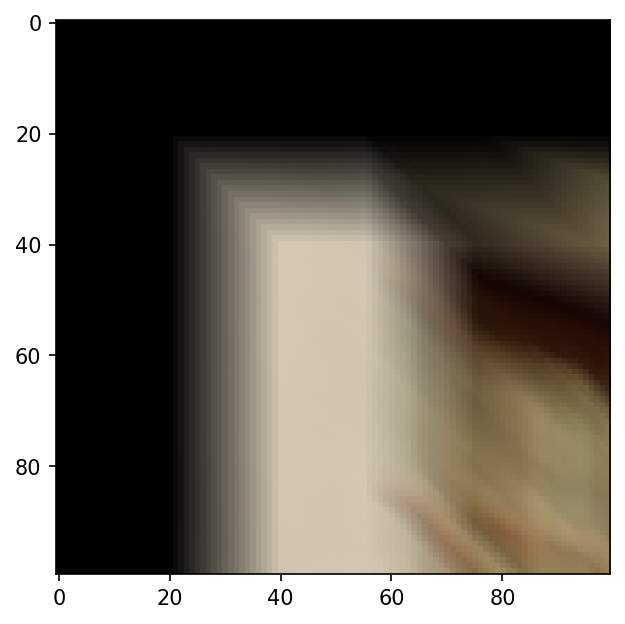

In [3]:
car_corner = car_rgb[:100,:100,:]
plt.imshow(car_corner);

In [4]:
# Debido a que se va trabajar con la imagen no en escala de 0 a 255, sino de 0 a 1, se normaliza el array
car_norm = car_rgb/255.0
print(f"El arreglo es tipo {car_norm.dtype}")

El arreglo es tipo float64


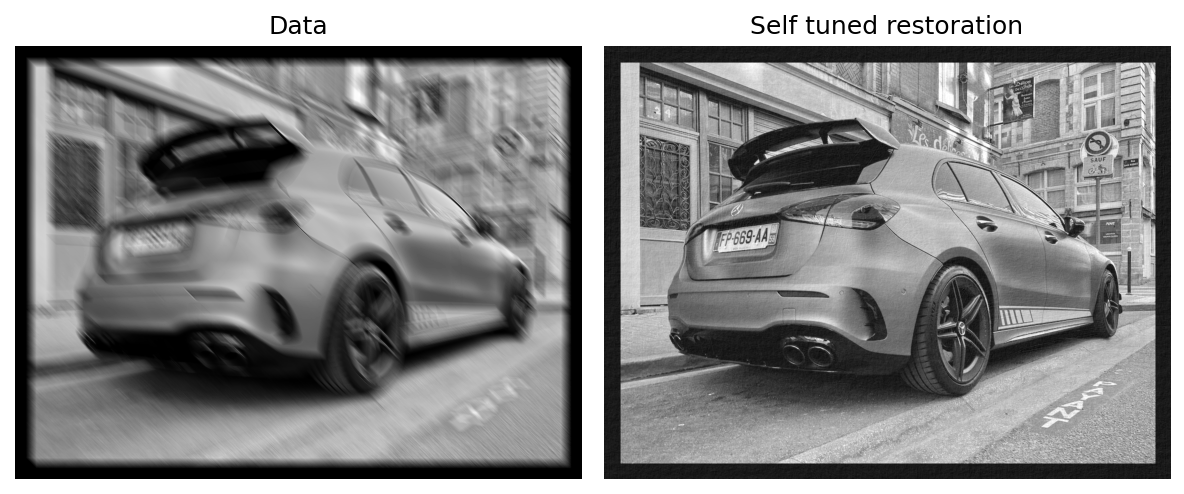

In [5]:
# Estas lineas hacían parte del código en link anexo de apoyo, pero 
# solo hacían parte del proceso de degradar la imagen
#rng = np.random.default_rng()
#car = conv2(car, psf, 'same')
#car += 0.1 * car.std() * rng.standard_normal(car.shape)

car = color.rgb2gray(car_norm)

# Como el proceso de degradación es de 20 pixeles en diagonal, el filtro 
# PSF es una matriz identidad 
psf = np.eye(20)
psf /= psf.sum()

deconvolved, _ = restoration.unsupervised_wiener(car, psf)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharex=True, sharey=True)

plt.gray()

ax[0].imshow(car)
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()

In [6]:
plate_1 = 'FP-669-AA'
img_restored_1 = deconvolved

## Segundo problema

Alex aún no aprende a sacar fotos. Ahora no movió la cámara pero olvidó enfocar, por lo que nuevamente no podemos leer la patente.

<img src="car_gaussian.png" alt="drawing" width="400"/>

Restaura la imagen para ayudar a Alex a recuperar la patente del auto. La imagen borrosa está almacenada en ```car_gaussian.npy```. Escribe la patente que descubras (sin guiones ni espacios) en ```plate_2``` y la imagen resultante (como un ```numpy.ndarray```) en ```img_restored_2```. ¡Suerte!

**¡Importante!** La imagen está almacenada en un archivo ```.npy```, por lo que deberás usar una función distinta a ```cv2.imread```para cargarla.


**Tip:** si le aplicáramos la misma degradación a un punto, se vería como la siguiente imagen.
<img src="psf.png" alt="drawing" width="400"/>

(810, 1060, 3)


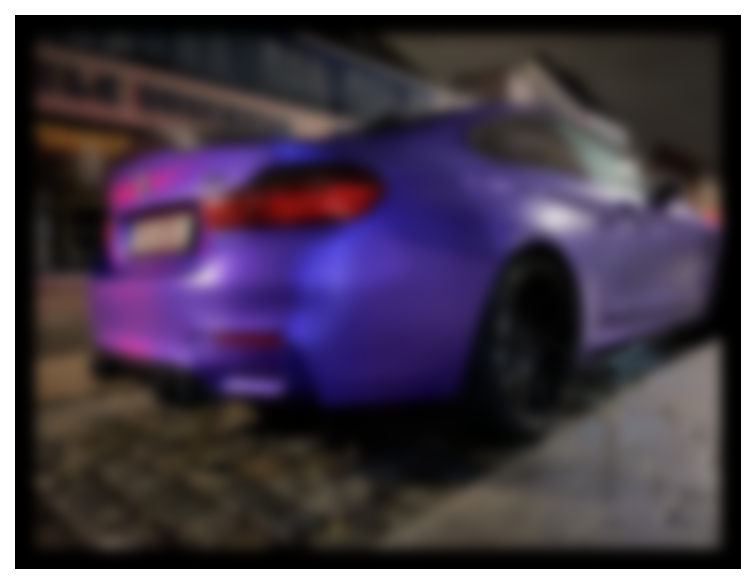

In [7]:
npy_car = np.load('car_gaussian.npy')
print(npy_car.shape)
plt.imshow(npy_car)
plt.axis('off');

In [36]:
car2_norm = npy_car/255.0
car2 = color.rgb2gray(car2_norm)

print(car2.shape)

car_size_y, car_size_x = car2.shape
car_x_center = car_size_x // 2
car_y_center = car_size_y // 2


def gaussian_psf(size, sigma):
    #"""Genera un PSF gaussiano de tamaño dado y desviación estándar sigma."""
    #ax = np.arange(-1060//2 +1.0, 1060//2 + 1.0)
    #ay = np.arange(-810//2 +1.0, 810//2 + 1.0)
    ax = np.arange(-250//2 + 1.0, 250//2 + 1.0)
    ay = np.arange(-170//2 + 1.0, 170//2 + 1.0)
    xx, yy = np.meshgrid(ax, ay)
    psf = np.exp(-(xx**2 + yy**2) / (1.5 * (sigma**2)))
    return psf / psf.sum()

# Definir el tamaño de la PSF y el sigma basado en la observación
sigma_value = 10
psf_size = 250  # Asegura cubrir suficiente área para el desenfoque
psf2 = gaussian_psf(psf_size, sigma_value)

(810, 1060)


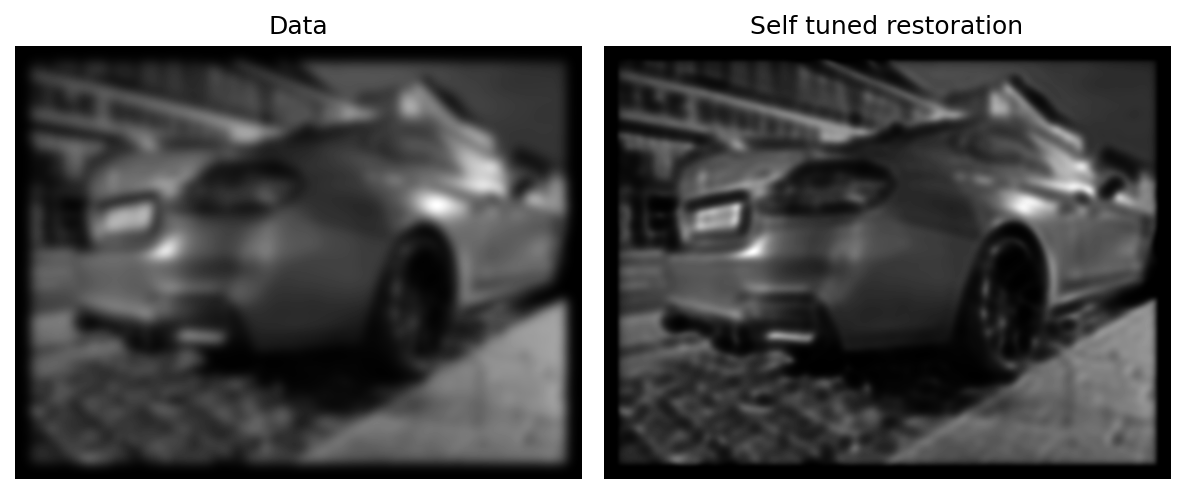

In [37]:
#img_restored_2, _ = restoration.unsupervised_wiener(car2, psf2)
img_restored_2 = restoration.richardson_lucy(car2, psf2, num_iter = 100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharex=True, sharey=True)

plt.gray()

ax[0].imshow(car2)
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(img_restored_2)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()